In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import allen_v1dd.stimulus_analysis.analysis_tools as at
import scipy.stats as stats
import statsmodels.stats.multicomp as multi
from scipy.stats import bootstrap
from statsmodels.stats.multicomp import pairwise_tukeyhsd as multi_pairwise_tukeyhsd
from scipy.stats import ks_2samp
from pathlib import Path
from allen_v1dd.client.ophys_session import OPhysSession
from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import StimulusAnalysis, DriftingGratings
from v1dd_public import ARTIFACT_DIR
from matplotlib.colors import LinearSegmentedColormap

This example for tuning properties is the Allen V1DD repository: https://github.com/AllenInstitute/allen_v1dd/blob/main/chase/analysis_notebooks/2022-09-12_dg-compare.ipynb

In [2]:
DATA_DIR = Path("/home/roozbehf/Documents/v1dd_arefeh/V1_DD_NWBs/")
NWB_DATA_DIR = DATA_DIR / "nwbs"
client =  OPhysClient(DATA_DIR)
nwb_file_paths = list(NWB_DATA_DIR.glob("processed/*.nwb"))  
path = nwb_file_paths[0]

mouse_id = "M409828"
col_vol_id = "13"
plane = 1
session = client.load_ophys_session(f"{mouse_id}_{col_vol_id}")
dg = DriftingGratings(session, plane, trace_type = "dff", dg_type = "full")

In [3]:
dg_full = []
dg_windowed = []

for plane in session.get_planes()[:1]:
    dg_full.append(DriftingGratings(session, plane, dg_type="full"))
    dg_windowed.append(DriftingGratings(session, plane, dg_type="windowed"))
print(f"Analyzing {len(dg_full)} plane{'s' if len(dg_full) > 1 else ''}")

Analyzing 1 plane


In [4]:
reset_metrics = True

if reset_metrics:
    for dgf, dgw in zip(dg_full, dg_windowed):
        dgf._metrics = None
        dgw._metrics = None
        dgf.fit_tuning_curve = False
        dgw.fit_tuning_curve = False

dgf_metrics = StimulusAnalysis.concat_metrics(dg_full)
dgw_metrics = StimulusAnalysis.concat_metrics(dg_windowed)
ss_metrics = DriftingGratings.compute_surround_suppression_metrics(dg_full, dg_windowed)
n_tot = len(dgf_metrics)
dgf_metrics = dgf_metrics[dgf_metrics.is_valid]
dgw_metrics = dgw_metrics[dgw_metrics.is_valid]
ss_metrics = ss_metrics[ss_metrics.is_valid]

dgf_metrics["is_responsive"] = dgf_metrics.is_valid & dgf_metrics.frac_responsive_trials >= 0.5
dgw_metrics["is_responsive"] = dgw_metrics.is_valid & dgw_metrics.frac_responsive_trials >= 0.5

resp_full = dgf_metrics["is_responsive"]
resp_windowed = dgw_metrics["is_responsive"]
n_valid = len(dgf_metrics) # same no. ROIs for both dg_full and dg_windowed
n_both = np.logical_and(resp_full, resp_windowed).value_counts()[True]
n_full = resp_full.value_counts()[True]
n_windowed = resp_windowed.value_counts()[True]
n_full_only = n_full - n_both
n_windowed_only = n_windowed - n_both
n_either = np.logical_or(resp_full, resp_windowed).value_counts()[True]
n_neither = np.logical_and(~resp_full, ~resp_windowed).value_counts()[True]

print()
print(f"{n_valid}/{n_tot} ({n_valid/n_tot*100:.1f}%) ROIs are valid")
print(f"{n_full}/{n_valid} ({n_full/n_valid*100:.1f}%) ROIs are responsive to DG-full")
print(f"{n_windowed}/{n_valid} ({n_windowed/n_valid*100:.1f}%) ROIs are responsive to DG-windowed")
print()
print(f"{n_either}/{n_valid} ({n_either/n_valid*100:.1f}%) ROIs are responsive to DG-full OR DG-windowed")
print(f"{n_both}/{n_valid} ({n_both/n_valid*100:.1f}%) ROIs are responsive to BOTH DG-full AND DG-windowed")
print(f"{n_full_only}/{n_valid} ({n_full_only/n_valid*100:.1f}%) ROIs are responsive to ONLY DG-full")
print(f"{n_windowed_only}/{n_valid} ({n_windowed_only/n_valid*100:.1f}%) ROIs are responsive to ONLY DG-windowed")
print(f"{n_neither}/{n_valid} ({n_neither/n_valid*100:.1f}%) ROIs are responsive to NEITHER")

Loading DG-full response metrics for session M409828_13, plane 1...
Loading DG-windowed response metrics for session M409828_13, plane 1...

409/1234 (33.1%) ROIs are valid
354/409 (86.6%) ROIs are responsive to DG-full
376/409 (91.9%) ROIs are responsive to DG-windowed

398/409 (97.3%) ROIs are responsive to DG-full OR DG-windowed
332/409 (81.2%) ROIs are responsive to BOTH DG-full AND DG-windowed
22/409 (5.4%) ROIs are responsive to ONLY DG-full
44/409 (10.8%) ROIs are responsive to ONLY DG-windowed
11/409 (2.7%) ROIs are responsive to NEITHER


In [5]:
import allen_v1dd.stimulus_analysis.analysis_tools as at
def response_plot(index, plot="tuning", **kwargs):
    at.dg_response_plot(index, dgf_metrics, dg_full, dg_windowed, plot=plot, **kwargs)
    print(f"SSI of {index} = {ss_metrics.at[index, 'ssi']:.4f}")
    # plt.savefig("dg_tts.eps", format= "eps")

SSI of M409828_13_1_64 = 0.1115


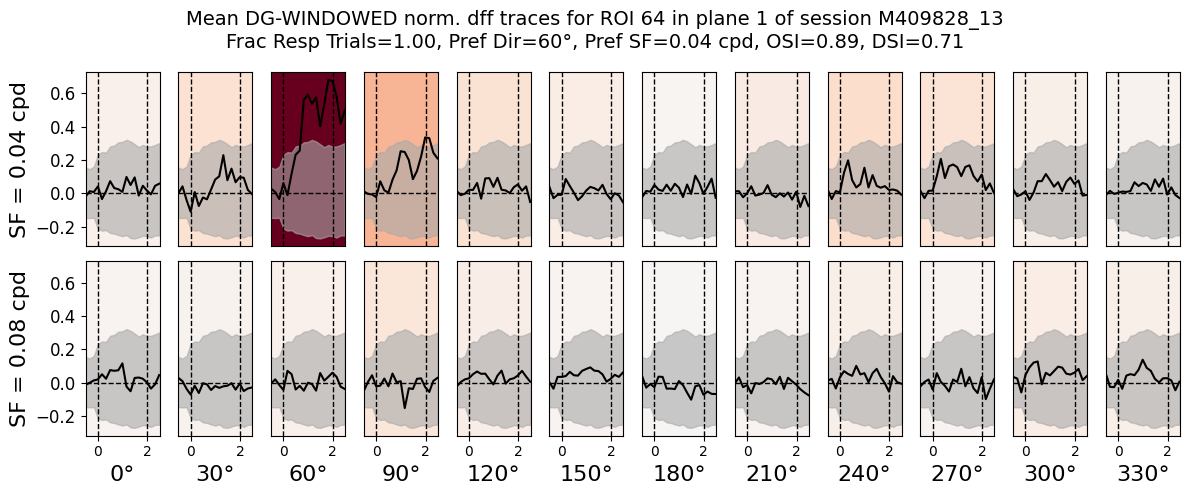

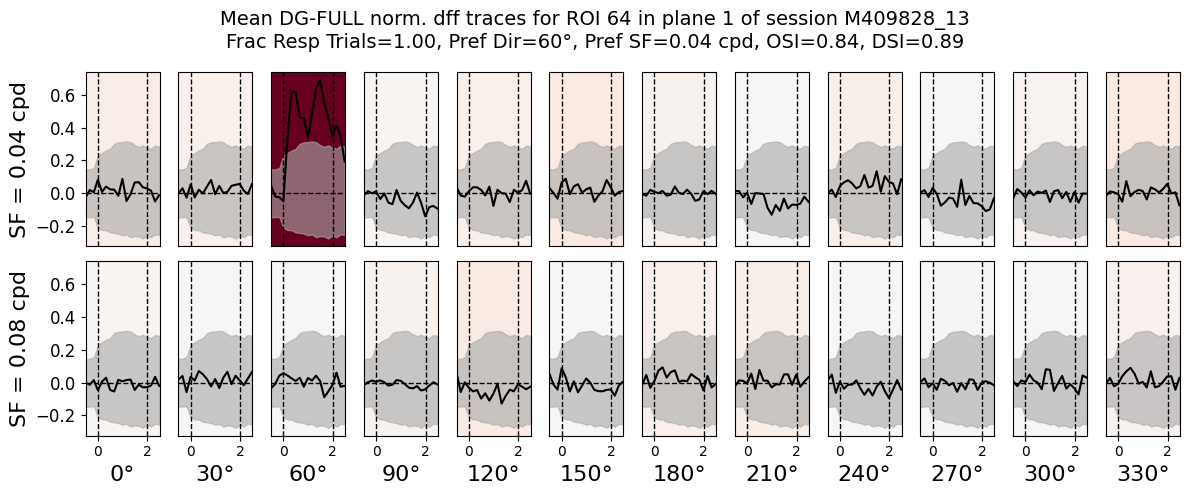

In [6]:
# response_plot("M409828_13_1_64", plot="condition_response", trace_type="events")
response_plot("M409828_13_1_64", plot="condition_response", trace_type="dff")

SSI of M409828_13_1_64 = 0.1115


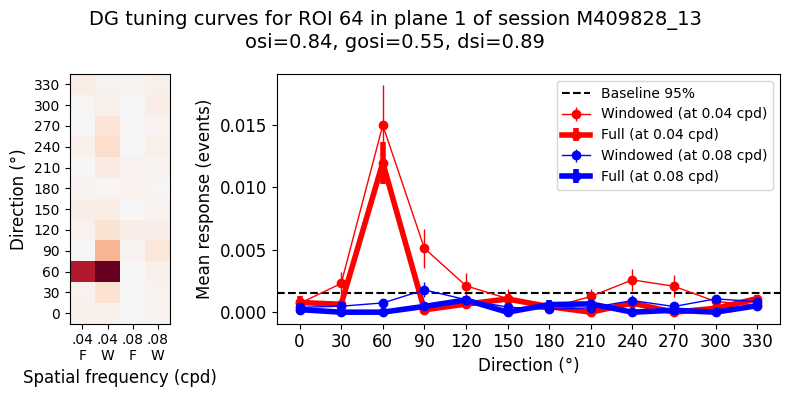

In [7]:
def response_plot(index, plot="tuning", **kwargs):
    at.dg_response_plot(index, dgf_metrics, dg_full, dg_windowed, plot=plot, **kwargs)
    print(f"SSI of {index} = {ss_metrics.at[index, 'ssi']:.4f}")
    # plt.savefig("dg_tuning.eps", format= "eps")
    
response_plot("M409828_13_1_64", plot="tuning")

[  0  30  60  90 120 150 180 210 240 270 300 330]
[-180 -150 -120  -90  -60  -30    0   30   60   90  120  150  180]
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]


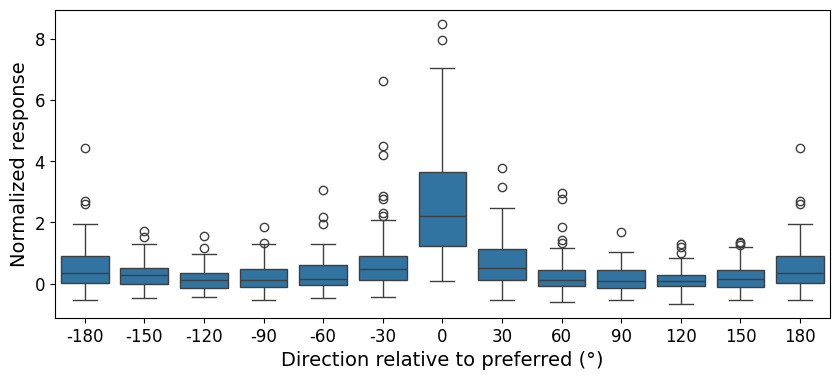

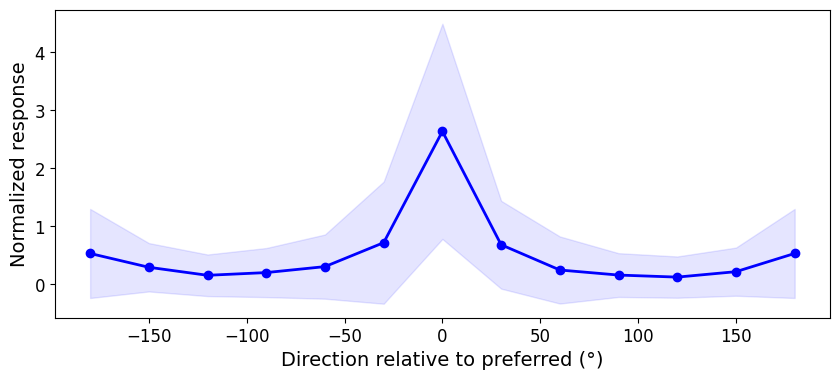

In [8]:
dg = dgw
dir_list = dg.dir_list
relative_dir_list = np.array([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
relative_dir_idx = np.arange(13) - 6

print(dir_list)
print(relative_dir_list)
print(relative_dir_idx)

x = []
y = []
y_ffsi = []

def ratio(a, b):
    if b == 0:
        return 0
    return a/b

for roi in range(dg.n_rois):
    if dg.is_roi_valid[roi] and dg.metrics.frac_responsive_trials[roi] >= 0.5:
        pref_dir_idx = dg.metrics.at[roi, "pref_dir_idx"]
        pref_sf_idx = dg.metrics.at[roi, "pref_sf_idx"]
        null_mean = dg._null_dist_multi_trial[roi].mean()
        null_std = dg._null_dist_multi_trial[roi].std()
        mean_grating_response = np.nanmean(dg.trial_responses[roi])
        mean_blank_response = dg.blank_responses[roi].mean()

        for dir_offset, reldir in zip(relative_dir_idx, relative_dir_list):
            dir_i = (pref_dir_idx+dir_offset) % len(dir_list)
            resp = dg.get_mean_response(roi, dir_i, pref_sf_idx)
            norm_resp = (resp - mean_blank_response) / (mean_grating_response + mean_blank_response)
            # norm_resp = (resp - null_mean) / null_std # z-score

            resp_f = dgf.get_mean_response(roi, dir_i, pref_sf_idx)
            # ffsi = ratio(resp - resp_f, resp)
            ffsi = ratio(max(resp, resp_f) - resp_f, max(resp, resp_f))

            x.append(reldir)
            y.append(norm_resp)
            y_ffsi.append(ffsi)

# Box plot
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
sns.boxplot(x=x, y=y, ax=ax)
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)
# ax.set_ylim(-5, 50)

# Line plot of means ± error
y_by_dir_idx = [[yy for xx, yy in zip(x, y) if xx == reldir] for reldir in relative_dir_list]
y_means = np.array([np.mean(arr) for arr in y_by_dir_idx])
y_err = np.array([np.std(arr) for arr in y_by_dir_idx])
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_means, color="blue", linewidth=2, marker=".", markersize=12)
ax.fill_between(relative_dir_list, y_means-y_err, y_means+y_err, color="blue", alpha=0.1)
# plt.savefig("dg_tuning_v2.eps", format= "eps")


In [ ]:
colors = [
    '#FF5733',  # Red
    '#33FF57',  # Green
    '#3357FF',  # Blue
    '#F1C40F',  # Yellow
    '#9B59B6',  # Purple
    'cyan',     # Cyan, named color
    'magenta',  # Magenta, named color
    '#FFC300',  # Gold
    '#DAF7A6',  # Light Green
    '#581845',  # Dark Purple
    '#34495E',  # Asphalt
    '#16A085',  # Green Sea
    '#E74C3C',  # Red Orange
    '#2980B9',  # Belize Hole Blue
    'chocolate' # Chocolate, named color
]

mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
z_groups_high_to_low = [[650, 675, 700, 725], [575, 600, 625], [500, 525, 550], [482, 498, 514], [434, 450, 466], \
    [386, 402, 418], [338, 354, 370], [290, 306, 322], [242, 258, 274], [194, 210, 226], [146, 162, 178], [98, 114, 130], [50, 66, 82]]


In [10]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [11]:
n_stimulus_pairs = 8
n_bootstrap = 1000
n_samples = 50
n_z_groups = len(z_groups_high_to_low)
n_mice = len(mice)
bootstrapped_data = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups, n_mice))

            
fig = plt.figure(figsize=(21, 7))

fontsize = 14
total_samples_per_group = [0] * len(z_groups_high_to_low)

titles = ['dgf_pref_dir', 'dgw_pref_dir', 'dgf_osi', 'dgw_osi', 'dgf_dsi', 'dgw_dsi', 'dgf_ls', 'dgw_ls']
for subplot_idx in range(n_stimulus_pairs):   
    for m, mouse_id in enumerate(mice):
 
        for z, z_group in enumerate(z_groups_high_to_low):
                plane = (cell_info['z'].isin(z_group)) & (cell_info['mouse_id']==mice[m])
                plane_df = cell_info[plane]
                
                for b in range(n_bootstrap):
                    sample_indices = np.random.choice(range(len(plane_df)), size=n_samples, replace=True)
                    sample_plane_df = plane_df.iloc[sample_indices]

                    if subplot_idx == 0:
                        stim_plane = (sample_plane_df['dgf_pref_dir'])
                    elif subplot_idx == 1:
                        stim_plane = (sample_plane_df['dgw_pref_dir'])
                    elif subplot_idx == 2:
                        stim_plane = (sample_plane_df['dgf_osi'])
                    elif subplot_idx == 3:
                        stim_plane = (sample_plane_df['dgw_osi'])
                    elif subplot_idx == 4:
                        stim_plane = (sample_plane_df['dgf_dsi'])
                    elif subplot_idx == 5:
                        stim_plane = (sample_plane_df['dgw_dsi'])
                    elif subplot_idx == 6:
                        stim_plane = (sample_plane_df['dgf_ls'])
                    else:
                        stim_plane = (sample_plane_df['dgw_ls'])   
                                         
                    stim_plane_df = stim_plane
                    
                    if len(stim_plane_df):
                        data = stim_plane_df.dropna().to_numpy()
                        bootstrapped_data[subplot_idx, b, z, m] = np.median(data)

<Figure size 2100x700 with 0 Axes>

In [12]:
def perform_anova(filtered_data):

    f_value, p_value = stats.f_oneway(*filtered_data)
    return f_value, p_value

def perform_tukeys_hsd_and_top_pairs(filtered_data):

    all_data = np.concatenate(filtered_data)
    groups = np.concatenate([np.full(len(sublist), i) for i, sublist in enumerate(filtered_data)])
    tukey_result = multi.pairwise_tukeyhsd(all_data, groups, 0.05)
    tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
    significant_pairs = tukey_df[tukey_df['p-adj'] < 0.05]
    significant_pairs_sorted = significant_pairs.sort_values(by='p-adj')

    print("\nTukey's HSD test result:")
    print(tukey_result)
    print(f"\nPairs with p-values < 0.05: {len(significant_pairs_sorted)} found")
    print(significant_pairs_sorted)
    
    return tukey_result, significant_pairs_sorted.to_records(index=False)

/tmp/ipykernel_4147718/881097244.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_tick_labels = [np.int(np.mean(group)) for group in z_groups_high_to_low]


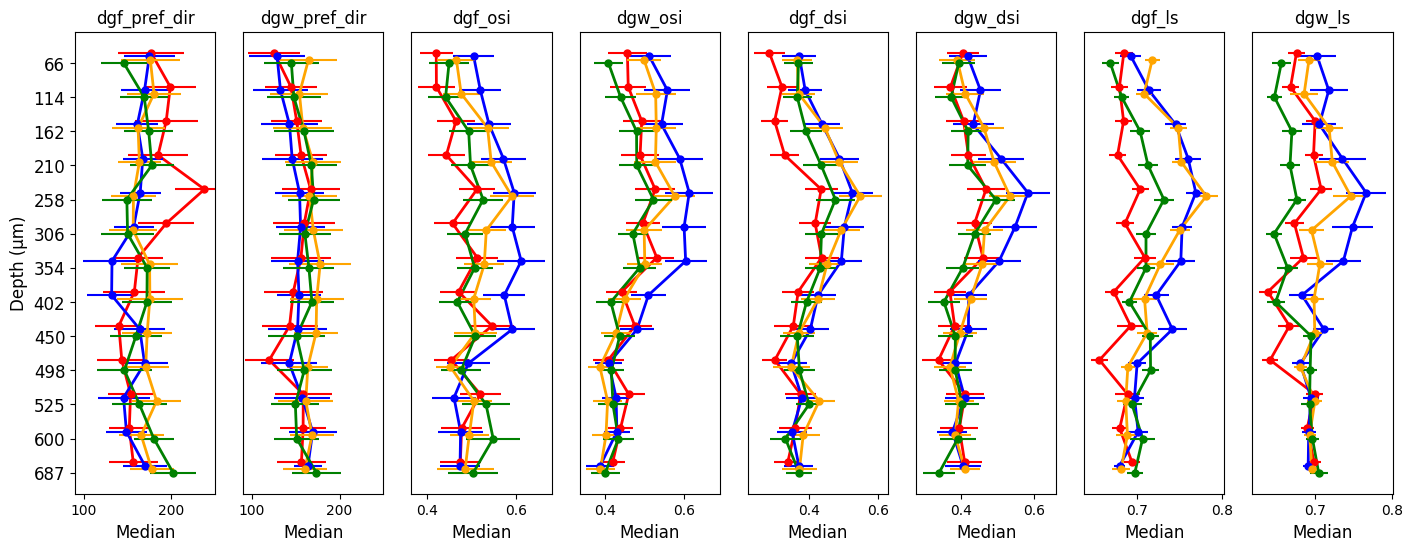

In [13]:
n_stimulus_pairs=8
jitter_amount = 0.15
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

fig = plt.figure(figsize=(17, 6))
for s in range(n_stimulus_pairs):
    ax = plt.subplot(1, n_stimulus_pairs, s + 1)
    
    for m, mouse_id in enumerate(mice):

        means = []
        std_errors = []
        mouse_color = mouse_colors[mice[m]]
        
        for z in range(n_z_groups):
            bootstrapped_values = bootstrapped_data[s, :, z, m]
            mean = np.mean(bootstrapped_values)
            std = np.std(bootstrapped_values)
            
            means.append(mean)
            std_errors.append(std)

        base_y_positions = np.arange(1, len(means) + 1)
        jitter = fixed_jitters[:, 3-m]
        y_positions = base_y_positions + jitter
        plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=5)
        plt.plot(means, y_positions, color=mouse_color, linewidth=2)
        plt.xlabel('Median', fontsize=12)
        plt.title(titles[s])

    
    if s == 0:
        y_tick_labels = [np.int(np.mean(group)) for group in z_groups_high_to_low]
        plt.yticks(y_positions, y_tick_labels, fontsize=12)
        plt.ylabel("Depth (µm)", fontsize=12)
    else:
        plt.yticks([])

    if s == 0 or s==1 :
        plt.xlim([90, 250])

# fig.savefig(f"dg_depth_plots.eps", format='eps')

(-60.0, 420.0)

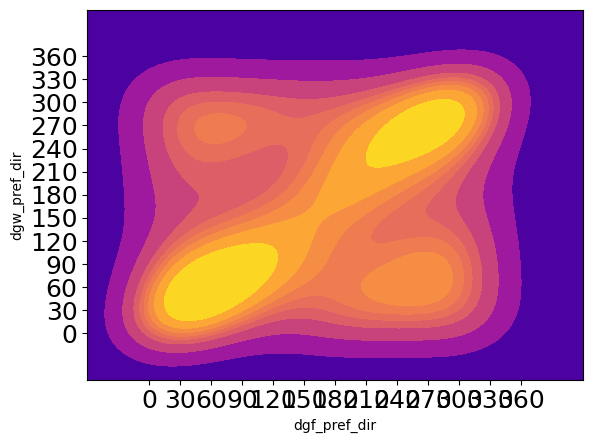

In [14]:
titles = ['dgf_pref_dir', 'dgw_pref_dir', 'dgf_osi', 'dgw_osi', 'dgf_dsi', 'dgw_dsi', 'dgf_ls', 'dgw_ls']
ax = sns.kdeplot(x=cell_info['dgf_pref_dir'], y=cell_info['dgw_pref_dir'], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font=20
plt.xticks(range(0, 361, 30), fontsize=font-2)
plt.yticks(range(0, 361, 30), fontsize=font-2)
plt.xlim(-60, 420)
plt.ylim(-60, 420)

<Axes: xlabel='dgf_dsi', ylabel='dgw_dsi'>

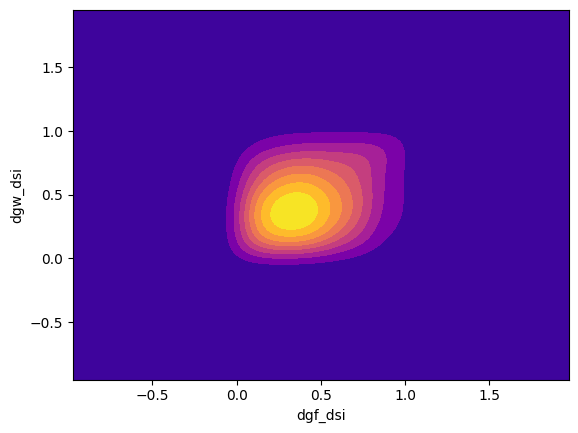

In [15]:
sns.kdeplot(x=cell_info['dgf_dsi'], y=cell_info['dgw_dsi'], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)

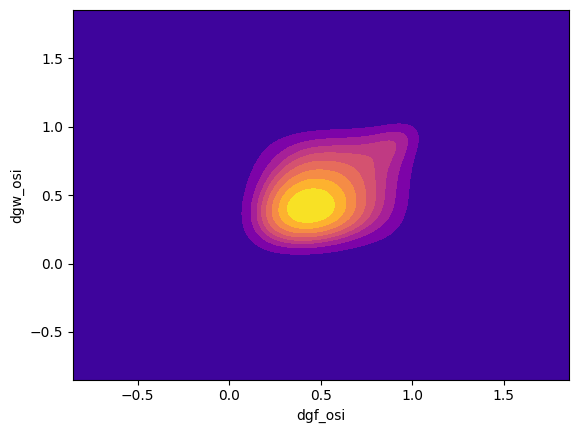

In [16]:
ax = sns.kdeplot(x=cell_info['dgf_osi'], y=cell_info['dgw_osi'], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)

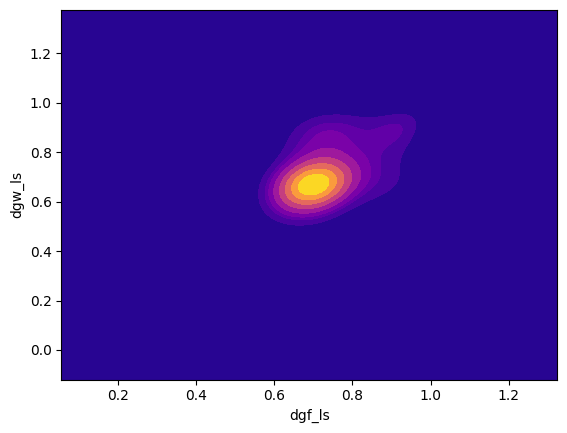

In [17]:
ax = sns.kdeplot(x=cell_info['dgf_ls'], y=cell_info['dgw_ls'], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)

Run the bootstrapping again regardless of the mouse id to run the statistics

In [18]:
n_stimulus_pairs = 8
n_bootstrap = 1000
n_samples = 50
n_z_groups = len(z_groups_high_to_low)
n_mice = len(mice)
bootstrapped_data = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups))

    
fig = plt.figure(figsize=(21, 7))

fontsize = 14
total_samples_per_group = [0] * len(z_groups_high_to_low)

titles = ['dgf_pref_dir', 'dgw_pref_dir', 'dgf_osi', 'dgw_osi', 'dgf_dsi', 'dgw_dsi', 'dgf_ls', 'dgw_ls']
for subplot_idx in range(n_stimulus_pairs):   
 
    for z, z_group in enumerate(z_groups_high_to_low):
            plane = (cell_info['z'].isin(z_group))
            plane_df = cell_info[plane]
            
            for b in range(n_bootstrap):
                sample_indices = np.random.choice(range(len(plane_df)), size=n_samples, replace=True)
                sample_plane_df = plane_df.iloc[sample_indices]

                if subplot_idx == 0:
                    stim_plane = (sample_plane_df['dgf_pref_dir'])
                elif subplot_idx == 1:
                    stim_plane = (sample_plane_df['dgw_pref_dir'])
                elif subplot_idx == 2:
                    stim_plane = (sample_plane_df['dgf_osi'])
                elif subplot_idx == 3:
                    stim_plane = (sample_plane_df['dgw_osi'])
                elif subplot_idx == 4:
                    stim_plane = (sample_plane_df['dgf_dsi'])
                elif subplot_idx == 5:
                    stim_plane = (sample_plane_df['dgw_dsi'])
                elif subplot_idx == 6:
                    stim_plane = (sample_plane_df['dgf_ls'])
                else:
                    stim_plane = (sample_plane_df['dgw_ls'])   
                                        
                stim_plane_df = stim_plane
                
                if len(stim_plane_df):
                    data = stim_plane_df.dropna().to_numpy()
                    bootstrapped_data[subplot_idx, b, z] = np.median(data)

<Figure size 2100x700 with 0 Axes>

/tmp/ipykernel_4147718/3000033973.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_tick_labels = [np.int(np.mean(group)) for group in z_groups_high_to_low]


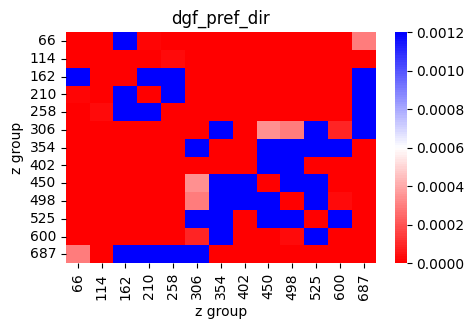

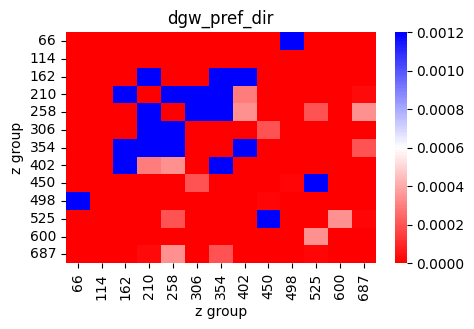

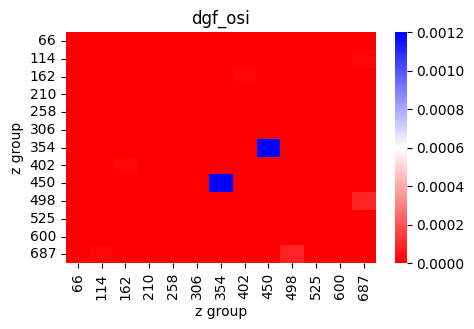

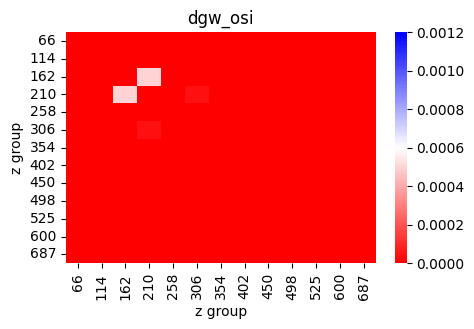

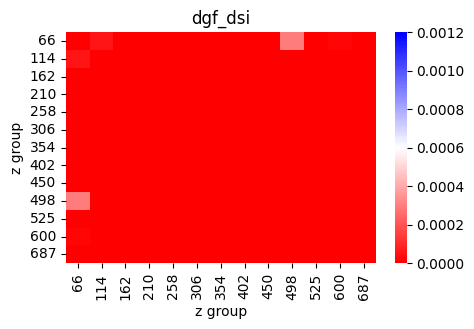

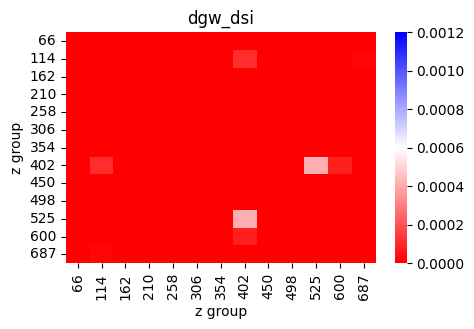

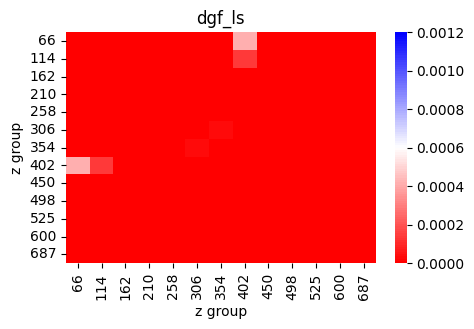

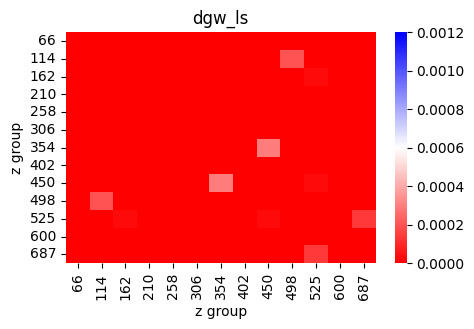

In [19]:
colors = ["red", "white", "blue"]
n_bins = 100
cmap_name = "custom_colormap"

cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
p_val = 0.0006#0.05/78
vmin, vmax = 0, p_val*2
norm = plt.Normalize(vmin=vmin, vmax=vmax)

p_value_matrix = np.ones((13, 13))
titles = ['dgf_pref_dir', 'dgw_pref_dir', 'dgf_osi', 'dgw_osi', 'dgf_dsi', 'dgw_dsi', 'dgf_ls', 'dgw_ls']
y_tick_labels = [np.int(np.mean(group)) for group in z_groups_high_to_low]

y_tick_labels = np.flip(y_tick_labels)

for s in range(8):

    data_to_plot = [bootstrapped_data[s, :, z] for z in range(n_z_groups)]
    significant_pairs = []

    # Pairwise Kolmogorov-Smirnov tests
    for i in range(len(data_to_plot)):
        for j in range(i+1, len(data_to_plot)):
            ks_stat, p_value = ks_2samp(data_to_plot[i], data_to_plot[j])

            if p_value < p_val:
                significant_pairs.append((i, j, p_value))
                p_value_matrix[j, i] = p_value
                p_value_matrix[i, j] = p_value

    np.fill_diagonal(p_value_matrix, 0)
    plt.figure(figsize=(5, 3))
    
    p_value_matrix = np.flip(np.flip(p_value_matrix, axis=0), axis=1)

    sns.heatmap(p_value_matrix, annot=False, cmap=cm, norm = norm, cbar=True,
                 xticklabels=y_tick_labels, yticklabels=y_tick_labels)

    plt.title(titles[s])
    plt.xlabel('z group')
    plt.ylabel('z group')
    plt.show()

In [20]:
correlation = cell_info['dgf_pref_dir'].corr(cell_info['dgw_pref_dir'])
correlation

0.11803380748798359

In [21]:
correlation = cell_info['dgf_dsi'].corr(cell_info['dgw_dsi'])
correlation

0.15053703895496517

In [22]:
correlation = cell_info['dgf_osi'].corr(cell_info['dgw_osi'])
correlation

0.2385102112752989

In [23]:
correlation = cell_info['dgf_ls'].corr(cell_info['dgw_ls'])
correlation

0.4034384985274456